In [1]:
# Repository setup and reproducibility
from pathlib import Path
import sys

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
print("Backend:", backend_info())
ensure_seed(42)

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

Backend: Backend=MLX version=0.29.3 device=DeviceType.gpu
Setup complete.


# Project 5: Decision Trees — Nonlinear Classification

## Goal
Build decision trees from scratch; understand recursive partitioning, information gain, and pruning.

## Learning Objectives
- Understand entropy, information gain, and Gini impurity
- Implement recursive tree building algorithm
- Visualize tree structure and decision boundaries
- Understand overfitting in trees (depth tradeoff)
- Compare greedy tree building to optimal trees

## Prerequisites
- Projects 1–4: familiar with classification and regularization

## What You'll Build
- NumPy-only decision tree; tree visualization; feature importance plots

## Estimated Time
- 3–5 hours

---

# Project 5: Decision Trees and Feature Importance

## Goal
Understand non-linear models and tree-based learning.

## Learning Objectives
- How trees partition input space
- What defines a good split
- Feature importance computation
- Tree depth and overfitting

In [2]:
# Setup (dynamic repo root discovery)
import sys
from pathlib import Path

def add_repo_root(marker_files=("requirements.txt","README.md",".git")):
    for candidate in [Path.cwd().resolve()] + list(Path.cwd().resolve().parents):
        if any((candidate / m).exists() for m in marker_files):
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    return None

REPO_ROOT = add_repo_root()
print(f"Repo root: {REPO_ROOT}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import make_classification

print("Ready to explore decision trees!")

Repo root: /Users/markcastillo/git/learning-ml-to-llm/projects/phase1_classical_ml
Ready to explore decision trees!


## Theoretical Foundation

### Information Gain (ID3)
$$IG(D, A) = H(D) - \sum_{v \in Values(A)} \frac{|D_v|}{|D|} H(D_v)$$

### Entropy
$$H(D) = -\sum_{i=1}^{c} p_i \log_2(p_i)$$

### Gini Impurity
$$Gini(D) = 1 - \sum_{i=1}^{c} p_i^2$$

Where $p_i$ is the proportion of samples belonging to class $i$.

## Step 1: Generate Classification Data

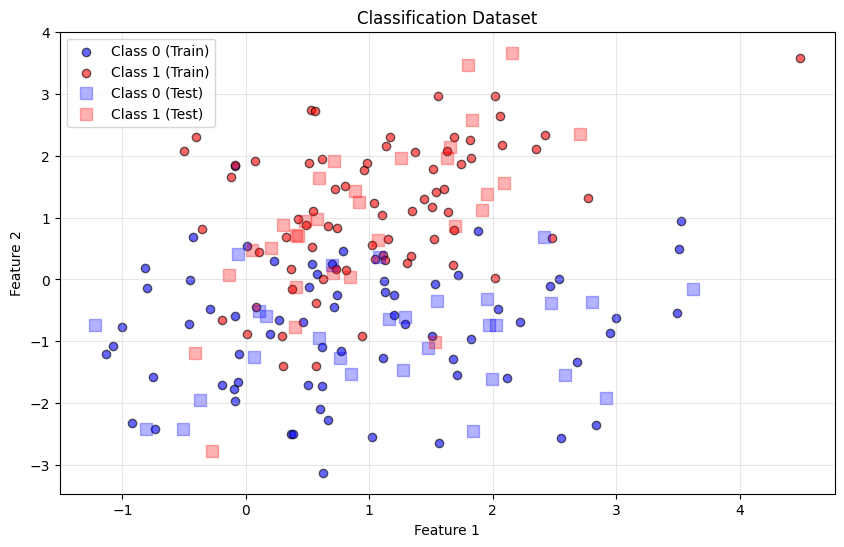

Training samples: 140
Test samples: 60
Class distribution (train): [68 72]
Class distribution (test): [29 31]


In [3]:
# Generate a simple 2D classification dataset
np.random.seed(42)
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, 
                          n_informative=2, n_clusters_per_class=1,
                          flip_y=0.05, random_state=42)

# Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
           c='blue', label='Class 0 (Train)', alpha=0.6, edgecolors='k')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
           c='red', label='Class 1 (Train)', alpha=0.6, edgecolors='k')
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], 
           c='blue', marker='s', label='Class 0 (Test)', alpha=0.3, s=80)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], 
           c='red', marker='s', label='Class 1 (Test)', alpha=0.3, s=80)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Class distribution (train): {np.bincount(y_train)}")
print(f"Class distribution (test): {np.bincount(y_test)}")

## Step 2: Implement Entropy and Gini Impurity

In [4]:
def entropy(y):
    """
    Calculate entropy of a label array.
    
    Parameters:
    -----------
    y : numpy array
        Class labels
        
    Returns:
    --------
    float
        Entropy value
    """
    if len(y) == 0:
        return 0
    
    # Calculate class probabilities
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    
    # Calculate entropy
    entropy_val = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy_val


def gini_impurity(y):
    """
    Calculate Gini impurity of a label array.
    
    Parameters:
    -----------
    y : numpy array
        Class labels
        
    Returns:
    --------
    float
        Gini impurity value
    """
    if len(y) == 0:
        return 0
    
    # Calculate class probabilities
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    
    # Calculate Gini impurity
    gini = 1 - np.sum(probabilities ** 2)
    return gini


# Test with different class distributions
test_cases = [
    ("Pure (all same class)", np.array([0, 0, 0, 0, 0])),
    ("Balanced (50-50)", np.array([0, 0, 1, 1])),
    ("Imbalanced (75-25)", np.array([0, 0, 0, 1])),
    ("Maximum impurity (uniform)", np.array([0, 1, 2, 3]))
]

print("Impurity Measures Comparison:")
print("=" * 70)
print(f"{'Distribution':<30} {'Entropy':<15} {'Gini':<15}")
print("=" * 70)

for desc, labels in test_cases:
    ent = entropy(labels)
    gini = gini_impurity(labels)
    print(f"{desc:<30} {ent:<15.4f} {gini:<15.4f}")

print("=" * 70)
print("\nKey Insights:")
print("• Pure splits have impurity = 0")
print("• More mixed splits have higher impurity")
print("• Both measures serve the same purpose: quantify node impurity")

Impurity Measures Comparison:
Distribution                   Entropy         Gini           
Pure (all same class)          -0.0000         0.0000         
Balanced (50-50)               1.0000          0.5000         
Imbalanced (75-25)             0.8113          0.3750         
Maximum impurity (uniform)     2.0000          0.7500         

Key Insights:
• Pure splits have impurity = 0
• More mixed splits have higher impurity
• Both measures serve the same purpose: quantify node impurity


## Step 3: Train Decision Trees with Different Depths

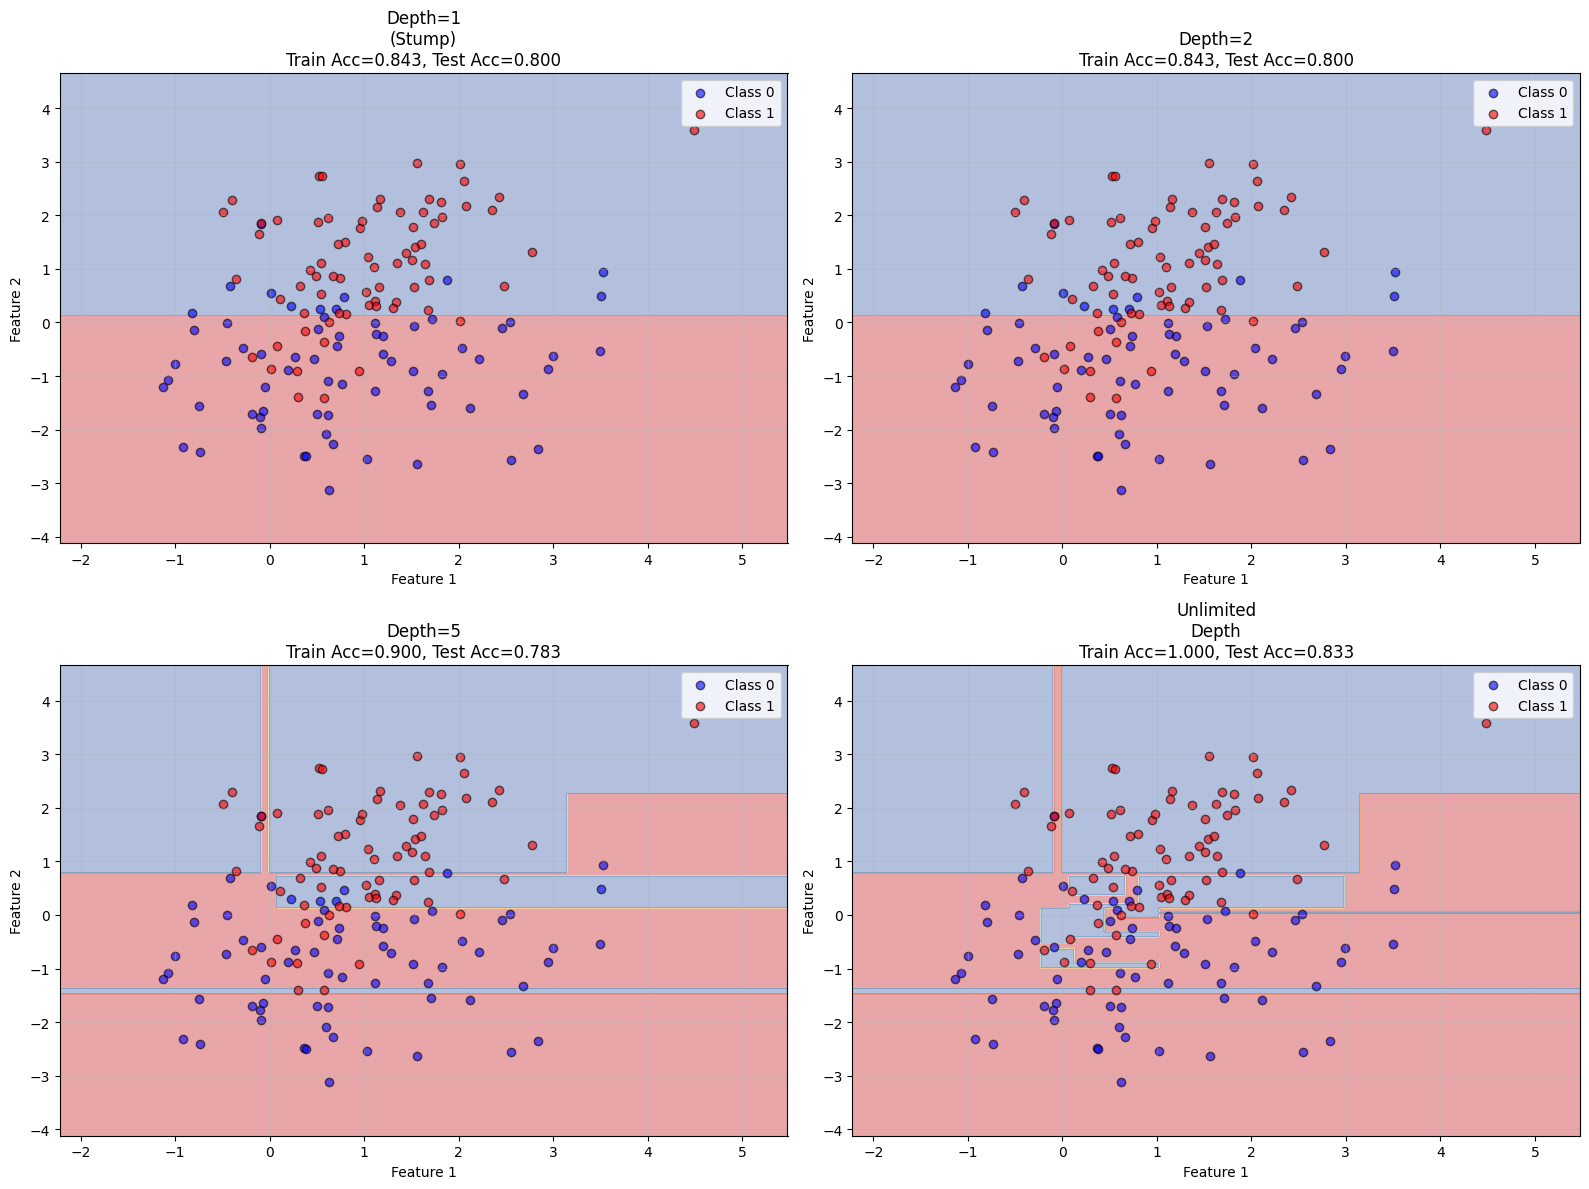

Tree Depth Analysis:
Max Depth       Train Acc       Test Acc        # Nodes        
Depth=1
(Stump) 0.8429          0.8000          3              
Depth=2         0.8429          0.8000          7              
Depth=5         0.9000          0.7833          29             
Unlimited
Depth 1.0000          0.8333          59             


In [5]:
# Train trees with different max depths
depths = [1, 2, 5, None]  # None means unlimited depth
depth_labels = ['Depth=1\n(Stump)', 'Depth=2', 'Depth=5', 'Unlimited\nDepth']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

trees = []

for idx, (depth, label) in enumerate(zip(depths, depth_labels)):
    # Train tree
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    trees.append(tree)
    
    # Calculate accuracy
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    
    # Create decision boundary plot
    ax = axes[idx]
    
    # Create mesh
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
              c='blue', label='Class 0', alpha=0.6, edgecolors='k')
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
              c='red', label='Class 1', alpha=0.6, edgecolors='k')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'{label}\nTrain Acc={train_acc:.3f}, Test Acc={test_acc:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("Tree Depth Analysis:")
print("=" * 70)
print(f"{'Max Depth':<15} {'Train Acc':<15} {'Test Acc':<15} {'# Nodes':<15}")
print("=" * 70)
for depth, tree in zip(depth_labels, trees):
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    n_nodes = tree.tree_.node_count
    print(f"{depth:<15} {train_acc:<15.4f} {test_acc:<15.4f} {n_nodes:<15}")
print("=" * 70)

## Step 4: Visualize Tree Structure

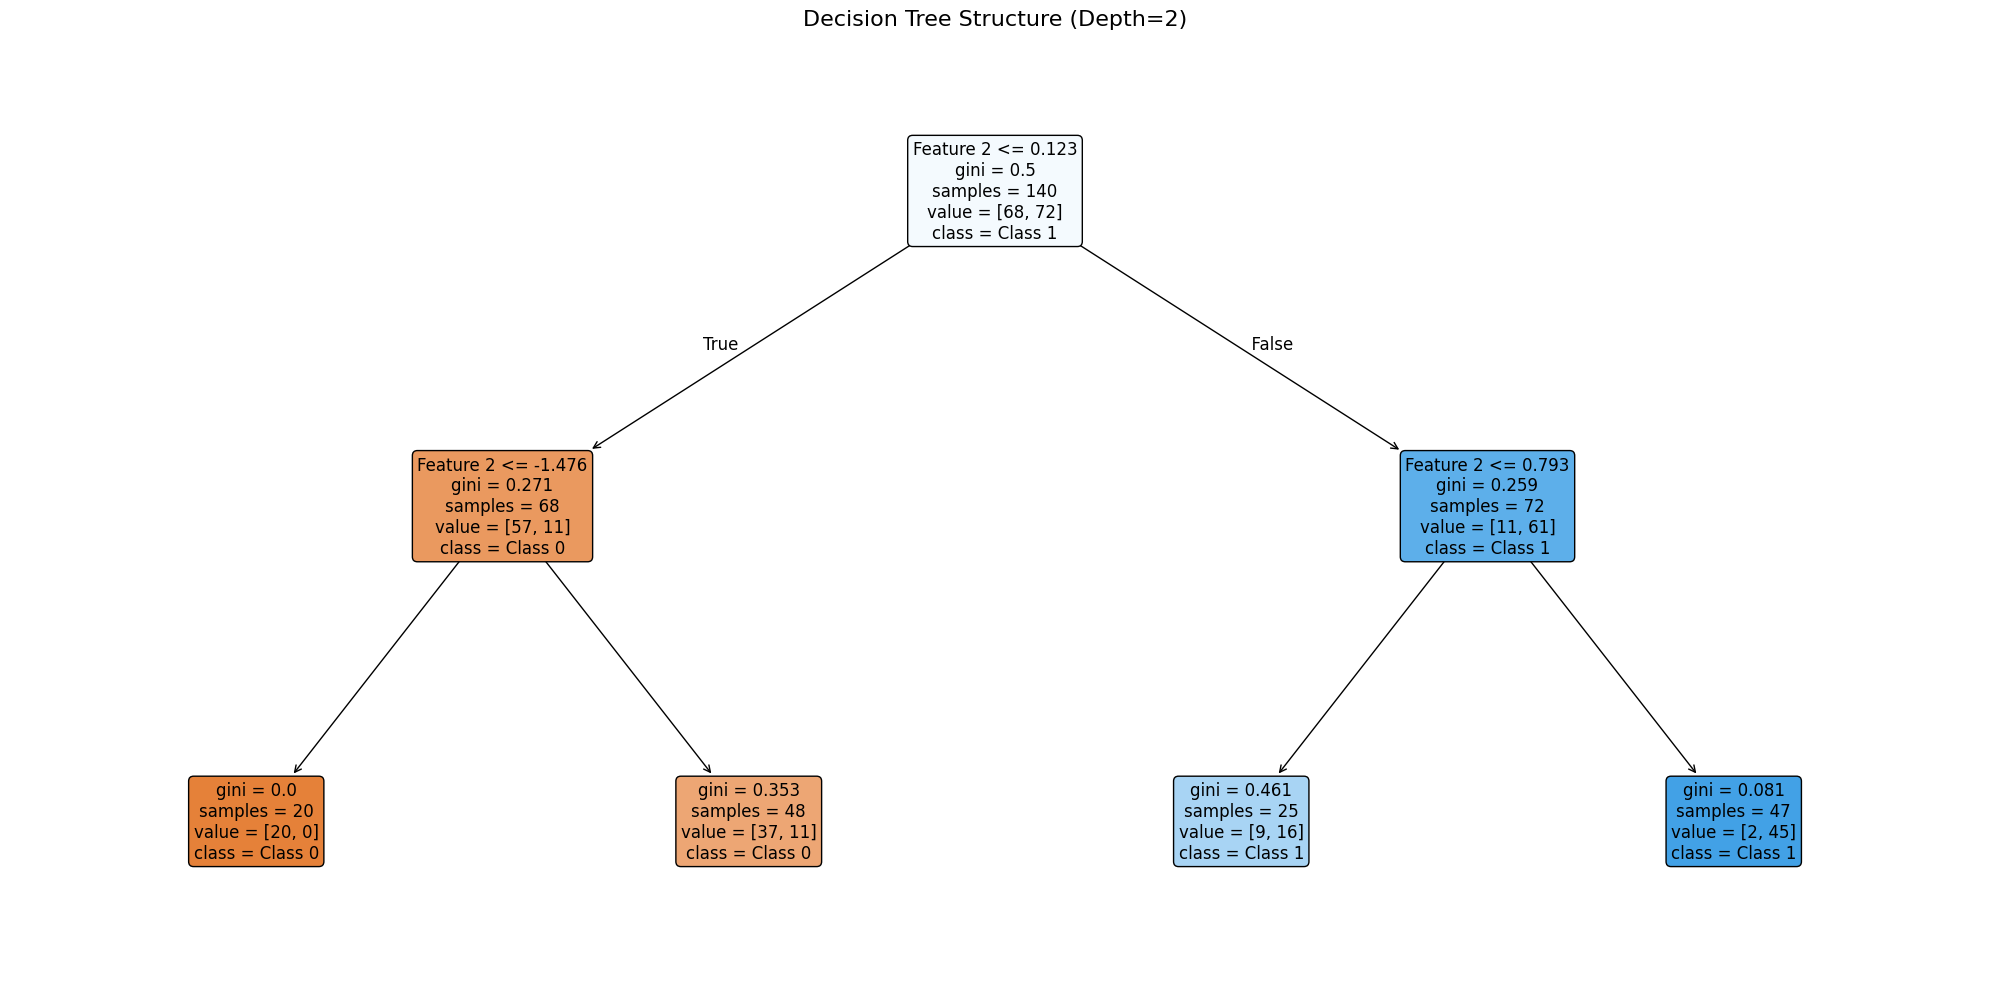

Understanding the Tree Structure:
• Each node shows:
  - Split criterion (e.g., 'Feature 1 <= 0.5')
  - Gini impurity at that node
  - Number of samples reaching that node
  - Class distribution [class_0_count, class_1_count]
  - Predicted class (majority class)

• Color indicates class prediction:
  - Blue shades = Class 0
  - Orange shades = Class 1
  - Darker color = more confident prediction (purer node)


In [6]:
# Visualize a small tree (depth=2) structure
tree_small = trees[1]  # Depth=2 tree

plt.figure(figsize=(20, 10))
plot_tree(tree_small, 
         feature_names=['Feature 1', 'Feature 2'],
         class_names=['Class 0', 'Class 1'],
         filled=True,
         rounded=True,
         fontsize=12)
plt.title('Decision Tree Structure (Depth=2)', fontsize=16)
plt.tight_layout()
plt.show()

print("Understanding the Tree Structure:")
print("=" * 70)
print("• Each node shows:")
print("  - Split criterion (e.g., 'Feature 1 <= 0.5')")
print("  - Gini impurity at that node")
print("  - Number of samples reaching that node")
print("  - Class distribution [class_0_count, class_1_count]")
print("  - Predicted class (majority class)")
print()
print("• Color indicates class prediction:")
print("  - Blue shades = Class 0")
print("  - Orange shades = Class 1")
print("  - Darker color = more confident prediction (purer node)")
print("=" * 70)

## Step 5: Feature Importance

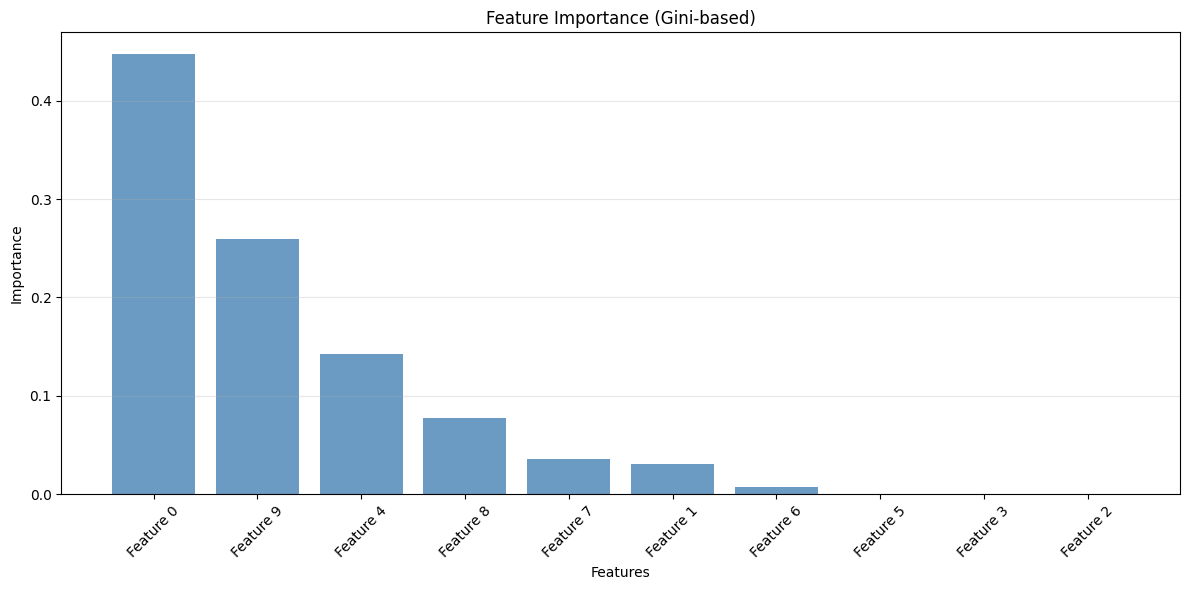

Feature Importance Ranking:
Rank     Feature              Importance      Cumulative %   
1        Feature 0            0.4470          44.7           %
2        Feature 9            0.2597          70.7           %
3        Feature 4            0.1420          84.9           %
4        Feature 8            0.0777          92.7           %
5        Feature 7            0.0359          96.2           %
6        Feature 1            0.0304          99.3           %
7        Feature 6            0.0072          100.0          %
8        Feature 5            0.0000          100.0          %
9        Feature 3            0.0000          100.0          %
10       Feature 2            0.0000          100.0          %

Model Accuracy: Train=0.9476, Test=0.7556

Key Insights:
• Feature importance = total impurity reduction from splits using that feature
• Higher importance = more useful for classification
• Can identify which features actually matter for prediction


In [7]:
# Generate data with more features (some informative, some not)
np.random.seed(42)
X_multi, y_multi = make_classification(n_samples=300, n_features=10, 
                                       n_informative=5, n_redundant=2, 
                                       n_repeated=0, n_classes=2,
                                       random_state=42)

# Split data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42)

# Train tree
tree_multi = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_multi.fit(X_train_multi, y_train_multi)

# Get feature importances
feature_names = [f'Feature {i}' for i in range(X_multi.shape[1])]
importances = tree_multi.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices], color='steelblue', alpha=0.8)
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Gini-based)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print detailed importance
print("Feature Importance Ranking:")
print("=" * 70)
print(f"{'Rank':<8} {'Feature':<20} {'Importance':<15} {'Cumulative %':<15}")
print("=" * 70)

cumsum = 0
for rank, idx in enumerate(indices, 1):
    cumsum += importances[idx]
    print(f"{rank:<8} {feature_names[idx]:<20} {importances[idx]:<15.4f} {cumsum*100:<15.1f}%")

print("=" * 70)
print(f"\nModel Accuracy: Train={tree_multi.score(X_train_multi, y_train_multi):.4f}, "
      f"Test={tree_multi.score(X_test_multi, y_test_multi):.4f}")

print("\nKey Insights:")
print("• Feature importance = total impurity reduction from splits using that feature")
print("• Higher importance = more useful for classification")
print("• Can identify which features actually matter for prediction")

## Step 6: Overfitting Analysis - Depth vs Performance

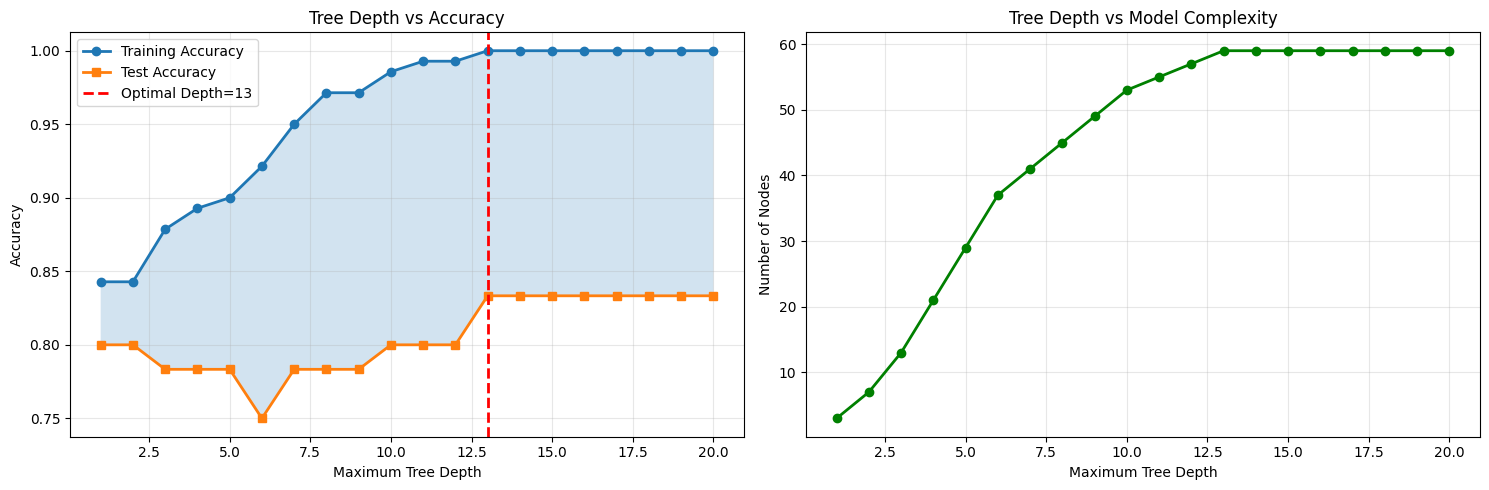

Depth vs Performance Analysis:
Optimal depth: 13
Best test accuracy: 0.8333
Train accuracy at optimal: 1.0000
Overfitting gap at optimal: 0.1667

Key Observations:
• Shallow trees (low depth): underfitting, low train & test accuracy
• Optimal depth: good balance, high test accuracy
• Deep trees (high depth): overfitting, perfect train but lower test accuracy
• Tree complexity (# nodes) grows exponentially with depth


In [8]:
# Analyze how tree depth affects overfitting
max_depths = range(1, 21)
train_accuracies = []
test_accuracies = []
n_nodes_list = []

for depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_accuracies.append(tree.score(X_train, y_train))
    test_accuracies.append(tree.score(X_test, y_test))
    n_nodes_list.append(tree.tree_.node_count)

# Find optimal depth
optimal_depth = max_depths[np.argmax(test_accuracies)]

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax = axes[0]
ax.plot(max_depths, train_accuracies, 'o-', label='Training Accuracy', linewidth=2, markersize=6)
ax.plot(max_depths, test_accuracies, 's-', label='Test Accuracy', linewidth=2, markersize=6)
ax.axvline(x=optimal_depth, color='red', linestyle='--', 
          label=f'Optimal Depth={optimal_depth}', linewidth=2)
ax.fill_between(max_depths, train_accuracies, test_accuracies, alpha=0.2)
ax.set_xlabel('Maximum Tree Depth')
ax.set_ylabel('Accuracy')
ax.set_title('Tree Depth vs Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Number of nodes plot
ax = axes[1]
ax.plot(max_depths, n_nodes_list, 'o-', color='green', linewidth=2, markersize=6)
ax.set_xlabel('Maximum Tree Depth')
ax.set_ylabel('Number of Nodes')
ax.set_title('Tree Depth vs Model Complexity')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Depth vs Performance Analysis:")
print("=" * 70)
print(f"Optimal depth: {optimal_depth}")
print(f"Best test accuracy: {max(test_accuracies):.4f}")
print(f"Train accuracy at optimal: {train_accuracies[optimal_depth-1]:.4f}")
print(f"Overfitting gap at optimal: {train_accuracies[optimal_depth-1] - test_accuracies[optimal_depth-1]:.4f}")
print()
print("Key Observations:")
print("• Shallow trees (low depth): underfitting, low train & test accuracy")
print("• Optimal depth: good balance, high test accuracy")
print("• Deep trees (high depth): overfitting, perfect train but lower test accuracy")
print("• Tree complexity (# nodes) grows exponentially with depth")
print("=" * 70)

## Step 7: Pruning - Min Samples Split

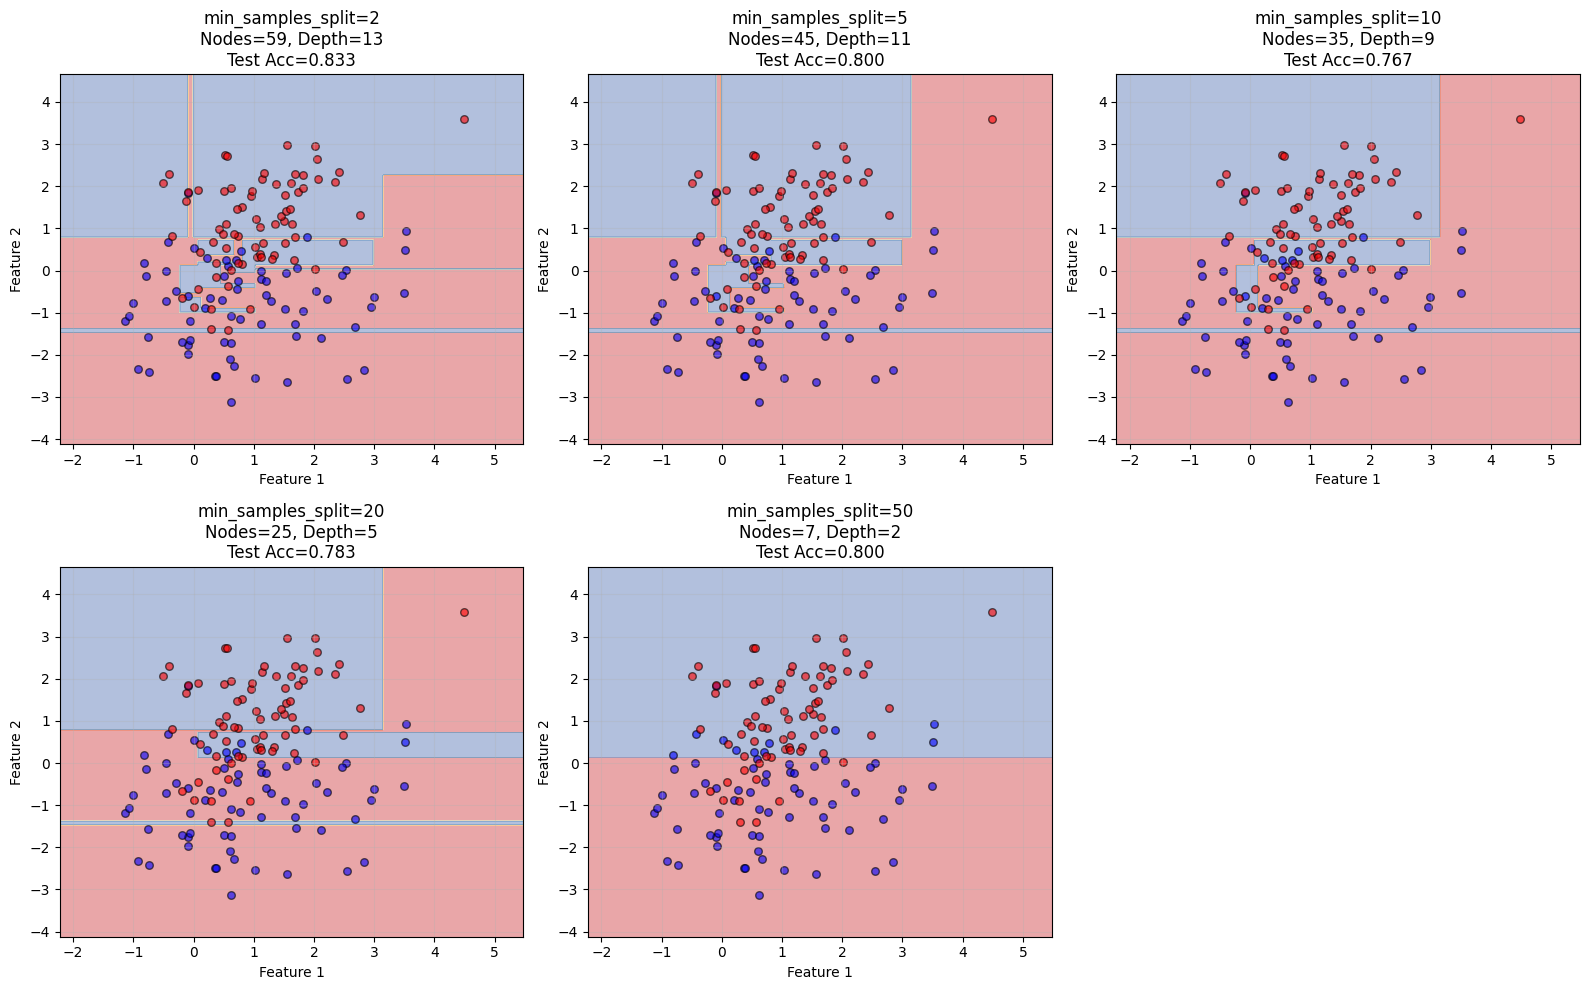

Pre-Pruning with min_samples_split:
min_samples_split    Nodes      Depth      Test Acc  
2                    59         13         0.8333    
5                    45         11         0.8000    
10                   35         9          0.7667    
20                   25         5          0.7833    
50                   7          2          0.8000    

• Larger min_samples_split → Simpler trees (fewer nodes)
• Prevents splitting on very small groups (reduces overfitting)
• Form of pre-pruning (stops growth early)


In [9]:
# Test different min_samples_split values (pre-pruning)
min_samples_splits = [2, 5, 10, 20, 50]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, min_split in enumerate(min_samples_splits):
    if idx >= len(axes):
        break
        
    # Train tree with min_samples_split constraint
    tree = DecisionTreeClassifier(min_samples_split=min_split, random_state=42)
    tree.fit(X_train, y_train)
    
    # Calculate metrics
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    n_nodes = tree.tree_.node_count
    max_depth_actual = tree.get_depth()
    
    # Plot decision boundary
    ax = axes[idx]
    
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
              c='blue', alpha=0.6, edgecolors='k', s=30)
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
              c='red', alpha=0.6, edgecolors='k', s=30)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'min_samples_split={min_split}\nNodes={n_nodes}, Depth={max_depth_actual}\nTest Acc={test_acc:.3f}')
    ax.grid(True, alpha=0.3)

# Remove extra subplot
if len(min_samples_splits) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

print("Pre-Pruning with min_samples_split:")
print("=" * 70)
print(f"{'min_samples_split':<20} {'Nodes':<10} {'Depth':<10} {'Test Acc':<10}")
print("=" * 70)

for min_split in min_samples_splits:
    tree = DecisionTreeClassifier(min_samples_split=min_split, random_state=42)
    tree.fit(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    print(f"{min_split:<20} {tree.tree_.node_count:<10} {tree.get_depth():<10} {test_acc:<10.4f}")

print("=" * 70)
print("\n• Larger min_samples_split → Simpler trees (fewer nodes)")
print("• Prevents splitting on very small groups (reduces overfitting)")
print("• Form of pre-pruning (stops growth early)")

## Step 8: Criterion Comparison (Gini vs Entropy)

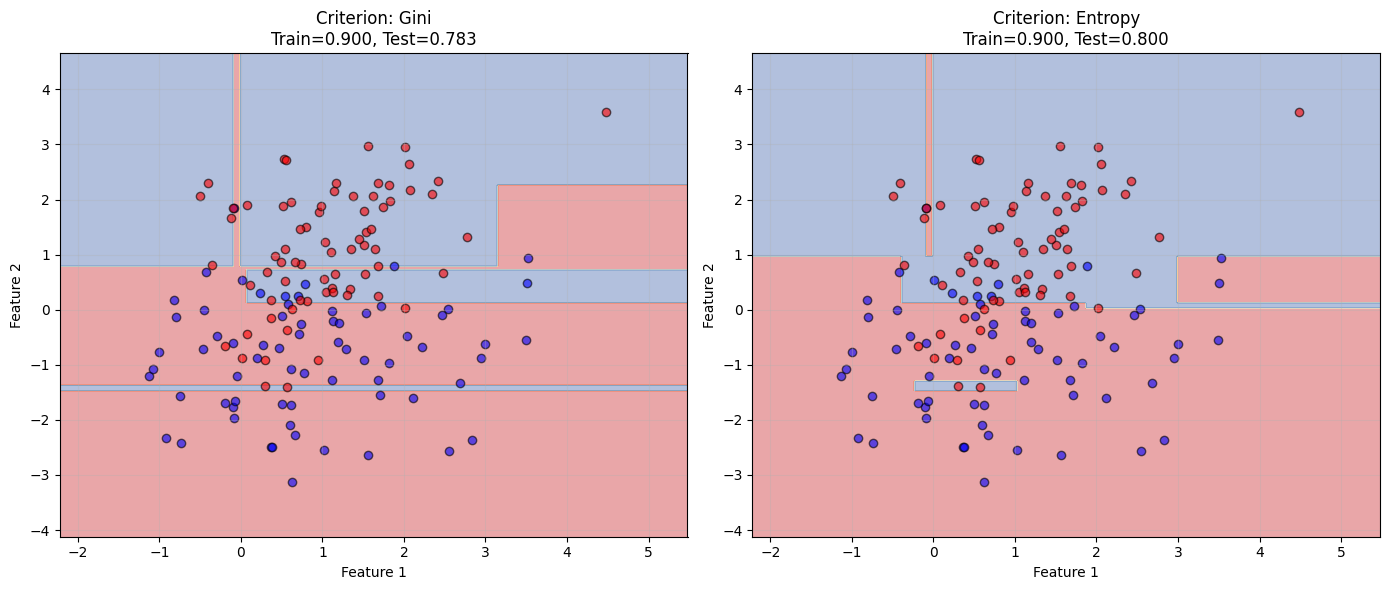

Gini vs Entropy Comparison:
Criterion       Train Acc       Test Acc        # Nodes        
Gini            0.9000          0.7833          29             
Entropy         0.9000          0.8000          27             

Key Insights:
• Both criteria typically produce similar results
• Gini: Faster to compute (no logarithm)
• Entropy: Slightly more balanced splits
• Default is 'gini' for efficiency
• Choice rarely makes a big difference in practice


In [10]:
# Compare Gini vs Entropy criteria
criteria = ['gini', 'entropy']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, criterion in enumerate(criteria):
    # Train tree
    tree = DecisionTreeClassifier(criterion=criterion, max_depth=5, random_state=42)
    tree.fit(X_train, y_train)
    
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    
    # Plot decision boundary
    ax = axes[idx]
    
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
              c='blue', alpha=0.6, edgecolors='k')
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
              c='red', alpha=0.6, edgecolors='k')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'Criterion: {criterion.capitalize()}\nTrain={train_acc:.3f}, Test={test_acc:.3f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare criteria performance
print("Gini vs Entropy Comparison:")
print("=" * 70)
print(f"{'Criterion':<15} {'Train Acc':<15} {'Test Acc':<15} {'# Nodes':<15}")
print("=" * 70)

for criterion in criteria:
    tree = DecisionTreeClassifier(criterion=criterion, max_depth=5, random_state=42)
    tree.fit(X_train, y_train)
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    n_nodes = tree.tree_.node_count
    print(f"{criterion.capitalize():<15} {train_acc:<15.4f} {test_acc:<15.4f} {n_nodes:<15}")

print("=" * 70)
print("\nKey Insights:")
print("• Both criteria typically produce similar results")
print("• Gini: Faster to compute (no logarithm)")
print("• Entropy: Slightly more balanced splits")
print("• Default is 'gini' for efficiency")
print("• Choice rarely makes a big difference in practice")

## Step 9: Visualize How Trees Partition Space

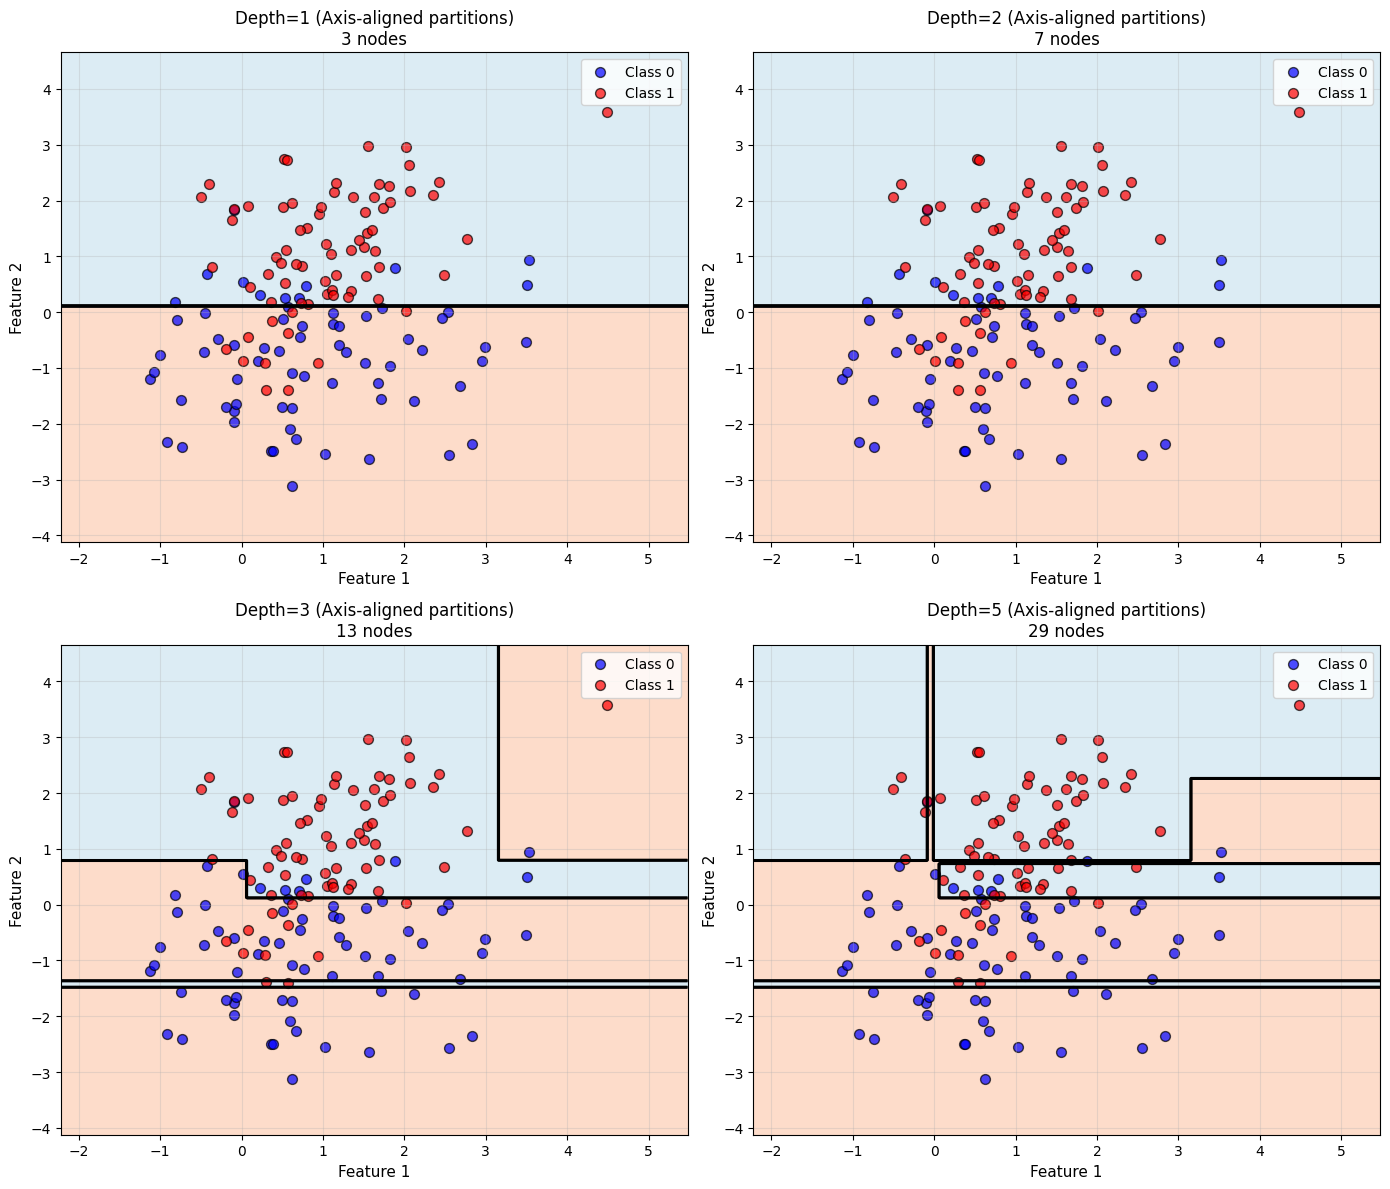

Space Partitioning Insights:
• Decision trees create AXIS-ALIGNED (rectangular) partitions
• Each split is parallel to a feature axis (e.g., x1 <= 0.5)
• Cannot create diagonal boundaries without multiple splits
• Deeper trees → more complex, finer-grained partitions
• Black lines show the decision boundaries between classes


In [11]:
# Visualize how decision boundaries partition the input space
depths = [1, 2, 3, 5]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, depth in enumerate(depths):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    ax = axes[idx]
    
    # Create finer mesh for better visualization
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict and plot
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Show regions with distinct colors
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=1)
    ax.contour(xx, yy, Z, colors='black', linewidths=2, levels=1)
    
    # Plot data points
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
              c='blue', alpha=0.7, edgecolors='k', s=50, label='Class 0')
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
              c='red', alpha=0.7, edgecolors='k', s=50, label='Class 1')
    
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_ylabel('Feature 2', fontsize=11)
    ax.set_title(f'Depth={depth} (Axis-aligned partitions)\n{tree.tree_.node_count} nodes', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Space Partitioning Insights:")
print("=" * 70)
print("• Decision trees create AXIS-ALIGNED (rectangular) partitions")
print("• Each split is parallel to a feature axis (e.g., x1 <= 0.5)")
print("• Cannot create diagonal boundaries without multiple splits")
print("• Deeper trees → more complex, finer-grained partitions")
print("• Black lines show the decision boundaries between classes")
print("=" * 70)

## Exercises & Extensions

**Warm-up**:
1. Compute entropy of a random variable: H = -Σ p_i log(p_i).
2. For a toy dataset, manually compute information gain for one split.
3. Draw tree structure by hand for a simple 2D classification.

**Intermediate**:
4. Vary max_depth. At what depth does the tree overfit?
5. Prune the tree. Does test accuracy improve?
6. Compare feature importance from Gini vs information gain.

**Advanced**:
7. Implement tree post-pruning using validation set.
8. Compare your tree to sklearn’s DecisionTreeClassifier. Are splits identical?
9. Plot learning curves (train/test accuracy vs tree depth).

---

## Summary & Bridge Forward

**What you learned**:
- Trees partition space recursively using greedy information gain.
- Entropy and impurity measure split quality.
- Deep trees overfit; shallow trees underfit.
- Feature importance reveals which features matter most.
- Trees are interpretable but unstable (small data changes cause different trees).

**Why this matters**:
- Trees are fundamentally different from linear models (nonlinear boundaries).
- Feature importance is useful for exploratory analysis.
- Ensembles of trees (bagging, boosting) achieve state-of-the-art performance.

**Next project** (Random Forests):
- Combine many trees via bootstrap aggregation (bagging).
- Reduce overfitting through averaging.

**Your takeaway**: Trees introduce nonlinearity and feature selection, but need ensembles to be competitive.

---

## 🎯 Summary: Key Insights on Decision Trees

### **Answering the Learning Objectives:**

#### 1️⃣ **How Decision Trees Partition Space**
- Decision trees create **axis-aligned rectangular partitions** in feature space
- Each split is **parallel to one feature axis** (e.g., x1 <= 0.5, x2 <= 1.3)
- Cannot create diagonal boundaries without multiple splits
- Recursive partitioning continues until stopping criteria are met

#### 2️⃣ **What Defines a "Good" Split**
- **Entropy**: Measures disorder/unpredictability. Lower is better.
  - Perfect split: entropy = 0 (all samples in a node are same class)
  - Worst split: entropy = 1 (equal mix of classes)
  
- **Gini Impurity**: Measures class mixing. Lower is better.
  - Perfect split: Gini = 0 (pure node)
  - Worst split: Gini = 0.5 (equal mix for binary classification)

- **Information Gain**: Reduction in entropy/Gini after a split
  - Trees choose splits that **maximize information gain**

#### 3️⃣ **How Trees Compute Feature Importance**
- Importance ∝ **weighted information gain** from splits using that feature
- Features used early and frequently → higher importance
- Features never used → zero importance
- Allows automatic feature selection

#### 4️⃣ **Tree Depth and Overfitting**
- **Shallow trees**: High bias, low variance (underfit)
- **Deep trees**: Low bias, high variance (overfit)
- **Optimal depth**: Balances bias-variance tradeoff
  - Found via cross-validation
  
- **Pre-pruning**: Stop growing early (max_depth, min_samples_split)
- **Post-pruning**: Build full tree, then remove branches (more complex)

---

### **🔑 Practical Takeaways**

✅ **Strengths of Decision Trees:**
- Easy to interpret and visualize
- No need for feature scaling
- Handles non-linear relationships naturally
- Built-in feature importance
- Works with mixed data types

❌ **Limitations:**
- Prone to overfitting (high variance)
- Axis-aligned splits can be inefficient for diagonal boundaries
- Small data changes can drastically change tree structure (unstable)
- Greedy splitting (may miss globally optimal tree)

💡 **Solution**: **Ensemble methods** like Random Forests and Gradient Boosting combine multiple trees to reduce variance while maintaining low bias.

---

### **Next Steps:**
- **Project 6**: Random Forests & Ensemble Methods
- Learn how bagging and feature randomization create more robust models
- Compare single tree vs. ensemble performance